# DeepDTA notebook

In [9]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
import torch
from tdc.multi_pred import DTI
from torch.utils.data import Dataset, DataLoader

# load in the three datasets
data_Kd = DTI(name = 'BindingDB_Kd')
data_ic50 = DTI(name = 'BindingDB_IC50')
data_Ki = DTI(name = 'BindingDB_Ki')

Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!


## ALS model
Model used is adapted from https://medium.com/@rinabuoy13/explicit-recommender-system-matrix-factorization-in-pytorch-f3779bb55d74

In [10]:
def data_split(data):
    # split data and get ID dicts
    split = data.get_split(method = 'random', seed = 42, frac = [0.6, 0.05, 0.35])
    train = split['train']
    test = split['test']

    train = train[['Drug_ID', 'Target', 'Y']].dropna()

    ID_to_Drug = dict(enumerate(list(dict.fromkeys(train['Drug_ID']))))
    ID_to_Target = dict(enumerate(list(dict.fromkeys(train['Target']))))

    Drug_to_ID = dict((v,k) for k,v in ID_to_Drug.items())
    Target_to_ID = dict((v,k) for k,v in ID_to_Target.items())
    return train, test, Drug_to_ID, Target_to_ID

def data_loader(data, drug_dict, target_dict):
    # load data into correct format
    data["Target_ID2"] = data["Target"].apply(lambda x:target_dict.get(x))
    data["Drug_ID2"] = data["Drug_ID"].apply(lambda x:drug_dict.get(x))
    data = data.dropna()

    drug_ID = data["Drug_ID2"].to_numpy()
    target_ID = data["Target_ID2"].to_numpy()
    features = np.vstack((drug_ID, target_ID)).T
    label = np.log(data['Y']).to_numpy()
    return features, label


class RatingDataset(Dataset):
    def __init__(self, train, label):
        self.feature_= train
        self.label_= label
    def __len__(self):
    #return size of dataset
        return len(self.feature_)
    def __getitem__(self, idx):
        return  torch.tensor(self.feature_[idx], dtype=torch.long),torch.tensor(self.label_[idx], dtype=torch.float)

In [11]:
class MatrixFactorization(torch.nn.Module):
    
    def __init__(self, n_users, n_items, n_factors):
        super().__init__()
        self.user_factors = torch.nn.Embedding(n_users, n_factors)
        self.item_factors = torch.nn.Embedding(n_items, n_factors)
        self.user_biases = torch.nn.Embedding(n_users, 1)
        self.item_biases = torch.nn.Embedding(n_items,1)
        torch.nn.init.xavier_uniform_(self.user_factors.weight)
        torch.nn.init.xavier_uniform_(self.item_factors.weight)
        self.user_biases.weight.data.fill_(0.)
        self.item_biases.weight.data.fill_(0.)
        
    def forward(self, user, item):
        pred = self.user_biases(user) + self.item_biases(item)
        pred += (self.user_factors(user) * self.item_factors(item)).sum(1, keepdim=True)
        return pred.squeeze()

In [12]:
def train_model(train_loader, test_loader, model, num_epochs=10):
    dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    loss_func = torch.nn.MSELoss()
    model.to(dev)
    
    train_losses = []
    test_losses = []
    for epoch in range(0,num_epochs):
        count = 0
        cum_loss = 0.
        for i, (train_batch, label_batch) in enumerate(train_loader):
            count = 1 + i
            # Predict and calculate loss for user factor and bias
            optimizer = torch.optim.SGD([model.user_biases.weight,model.user_factors.weight], lr=0.01, weight_decay=1e-5) # learning rate
            prediction = model(train_batch[:,0].to(dev), train_batch[:,1].to(dev))
            loss = loss_func(prediction, label_batch.to(dev)).float()    
            # Backpropagate
            loss.backward()

            # Update the parameters
            optimizer.step()
            optimizer.zero_grad()

            #predict and calculate loss for item factor and bias
            optimizer = torch.optim.SGD([model.item_biases.weight,model.item_factors.weight], lr=0.01, weight_decay=1e-5) # learning rate
            prediction = model(train_batch[:,0].to(dev), train_batch[:,1].to(dev))
            loss = loss_func(prediction, label_batch.to(dev))
            loss_item = loss.item()
            if loss_item > 0:
                cum_loss += loss_item
            else:
                count -= 1

            # Backpropagate
            loss.backward()

            # Update the parameters
            optimizer.step()
            optimizer.zero_grad()
        train_loss = cum_loss/count
        train_losses.append(train_loss)

        cum_loss =0.
        count = 0
        for i, (test_batch, label_batch) in enumerate(test_loader):
            count = 1 + i
            with torch.no_grad():
                prediction = model(test_batch[:,0].to(dev), test_batch[:,1].to(dev))
                loss = loss_func(prediction, label_batch.to(dev))
                loss_item = loss.item()
                if loss_item > 0:
                    cum_loss += loss_item
                else:
                    count -= 1
                
        test_loss = cum_loss/count
        test_losses.append(test_loss)
        if epoch % 2 == 0:
            print('epoch: ', epoch ,' avg training loss: ', train_loss, ' avg test loss: ',test_loss)
    return train_losses, test_losses

In [13]:
def model(data, img_name, n_factors=100, bs=100, num_epochs=100):
    train, test, drug_dict, target_dict = data_split(data)
    x_train, y_train = data_loader(train, drug_dict, target_dict)
    x_test, y_test = data_loader(test, drug_dict, target_dict)

    train_dataloader = DataLoader(RatingDataset(x_train, y_train), batch_size=bs, shuffle=True)
    test_dataloader = DataLoader(RatingDataset(x_test, y_test), batch_size=bs)

    model = MatrixFactorization(len(drug_dict), len(target_dict), n_factors=n_factors)

    train_losses, test_losses = train_model(train_dataloader, test_dataloader, model, num_epochs)
    
    epochs = range(1, num_epochs+1)
    plt.plot(epochs, train_losses, label='train')
    plt.plot(epochs, test_losses, label='test')
    plt.xlabel('epoch')
    plt.ylabel('mse loss')
    plt.legend()
    plt.title(img_name)
    plt.savefig(img_name)
    plt.show()

## Kd Dataset

epoch:  0  avg training loss:  56.41564010814497  avg test loss:  52.03300029209682
epoch:  2  avg training loss:  41.22963240192195  avg test loss:  36.22988053730556
epoch:  4  avg training loss:  31.6291447718432  avg test loss:  26.59494671140398
epoch:  6  avg training loss:  25.68818506617455  avg test loss:  20.56873091288975
epoch:  8  avg training loss:  21.768631625327334  avg test loss:  16.705149705069406
epoch:  10  avg training loss:  19.172785947277287  avg test loss:  14.163890286854334
epoch:  12  avg training loss:  17.338591539176406  avg test loss:  12.450027281897409
epoch:  14  avg training loss:  16.031898492460797  avg test loss:  11.261730091912407
epoch:  16  avg training loss:  15.035252479990577  avg test loss:  10.413570751462665
epoch:  18  avg training loss:  14.300266153493505  avg test loss:  9.788303736277989


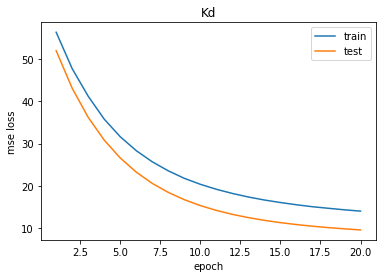

In [14]:
model(data_Kd, 'Kd', bs=100, num_epochs=20)

## IC50 Dataset

In [15]:
#model(data_ic50, 'ic50', n_factors=20, bs=100, num_epochs=20)

## Ki Dataset

In [ ]:
#model(data_Ki, 'Ki', bs=100, num_epochs=20)